# Ultimate Take Home Challenge Part 3 - Predictive Modeling

In [1]:
# Import packages
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load JSON data file
with open('ultimate_data_challenge.json', 'r') as f:
    data = json.load(f)

In [3]:
ultimate_df = pd.DataFrame(data)
ultimate_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [4]:
ultimate_df.shape

(50000, 12)

In [5]:
# Converting date columns to datettime
ultimate_df['signup_date'] = pd.to_datetime(ultimate_df['signup_date'])
ultimate_df['last_trip_date'] = pd.to_datetime(ultimate_df['last_trip_date'])

# Determining the cutoff for "retained" definition
cutoff_date = ultimate_df['last_trip_date'].max()

# Creating a 'retained' column: True if last trip was within 30 days of cutoff
ultimate_df['retained'] = ultimate_df['last_trip_date'] >= (cutoff_date - pd.Timedelta(days=30))

# Summary statistics of retention rate and any missing values
retention_rate = ultimate_df['retained'].mean()
missing_summary = ultimate_df.isna().sum()

retention_rate, missing_summary

(0.37608,
 city                         0
 trips_in_first_30_days       0
 signup_date                  0
 avg_rating_of_driver      8122
 avg_surge                    0
 last_trip_date               0
 phone                      396
 surge_pct                    0
 ultimate_black_user          0
 weekday_pct                  0
 avg_dist                     0
 avg_rating_by_driver       201
 retained                     0
 dtype: int64)

- Retention rate is **~37.6%**
- Missing values include:
    - avg_rating_of_driver (8,122)
    - phone (396)
    - avg_rating_by_driver: 201 

## Data cleaning

Since the **phone** feature can't be imputed and the amount of missing rows from the feature makes up less than 1% of the data, we'll drop these rows from the dataset.

In [6]:
# Drop misisng values from "phone" since there are very few missing values
cleaned_df = ultimate_df.dropna(subset=['phone'])

For the other rows with imputable features, let's plot their distributions for a better look to see if we should impute with mean or median.

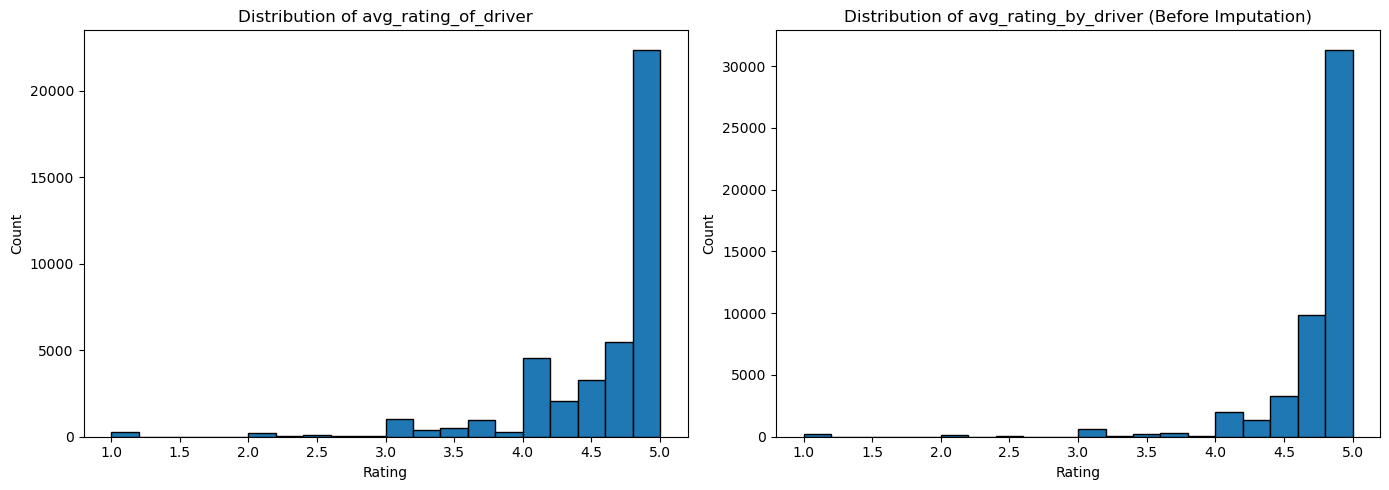

In [7]:
# Distribution of avg_rating_of_driver and avg_rating_by_driver
fig, ax = plt.subplots(1,2, figsize=(14,5))

ax[0].hist(cleaned_df['avg_rating_of_driver'].dropna(), bins=20, edgecolor='black')
ax[0].set_title('Distribution of avg_rating_of_driver')
ax[0].set_xlabel('Rating')
ax[0].set_ylabel('Count')

ax[1].hist(cleaned_df['avg_rating_by_driver'].dropna(), bins=20, edgecolor='black')
ax[1].set_title('Distribution of avg_rating_by_driver (Before Imputation)')
ax[1].set_xlabel('Rating')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

Since they are both skewed, we will impute with their respective medians.

In [8]:
# Drop rows with missing phone
cleaned_df = ultimate_df.dropna(subset=['phone']).copy()

# Imputing avg_rating_of_driver and avg_rating_of_driver with median
cleaned_df['avg_rating_of_driver'].fillna(cleaned_df['avg_rating_of_driver'].median(), inplace=True)
cleaned_df['avg_rating_by_driver'].fillna(cleaned_df['avg_rating_by_driver'].median(), inplace=True)

In [9]:
# Checking to see if all the misisng values are resolved
cleaned_df.isna().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
retained                  0
dtype: int64

In [10]:
# Copying the cleaned df into the simple df variable
df = cleaned_df.copy()

## Exploratory Data Analysis

We will take a look at the distribution by categorical and continuous variables.

### Retention rate by categorical variable

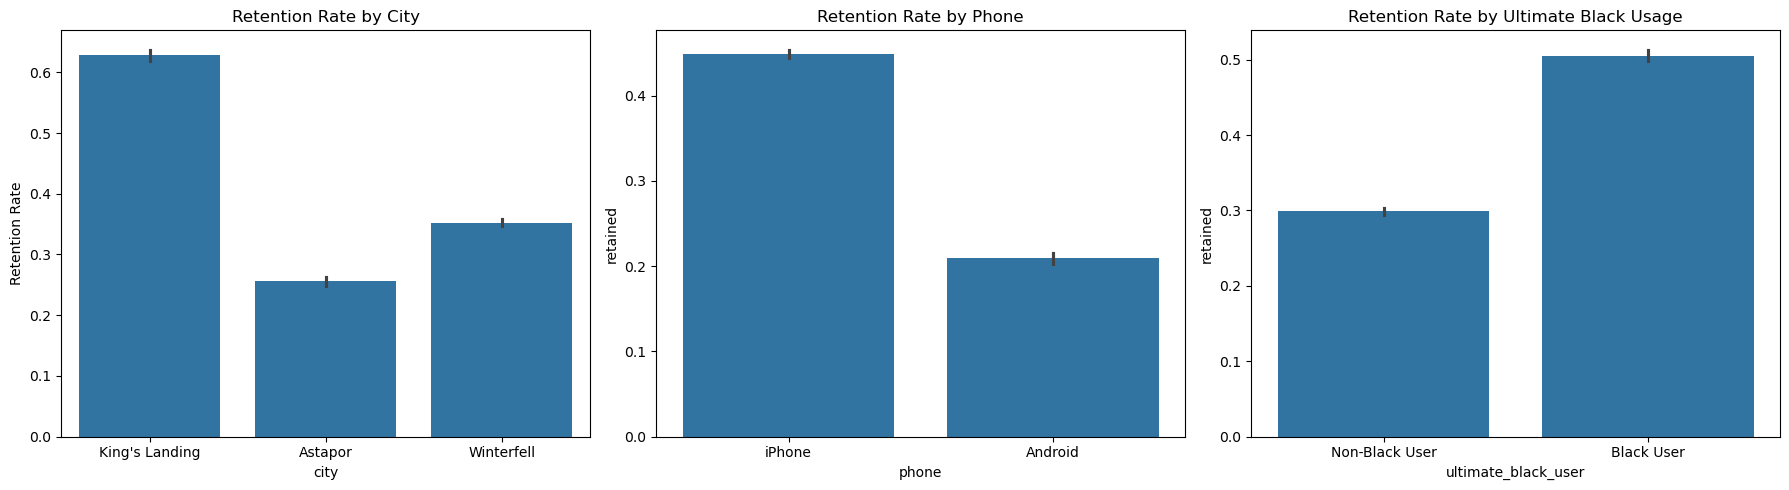

In [11]:
fig, ax = plt.subplots(1,3, figsize=(18,5))

# Retention by city
sns.barplot(x='city', y='retained', data=df, ax=ax[0])
ax[0].set_title('Retention Rate by City')
ax[0].set_ylabel('Retention Rate')

# Retention by phone
sns.barplot(x='phone', y='retained', data=df, ax=ax[1])
ax[1].set_title('Retention Rate by Phone')

# Retention by Ultimate Black User
sns.barplot(x='ultimate_black_user', y='retained', data=df, ax=ax[2])
ax[2].set_title('Retention Rate by Ultimate Black Usage')
ax[2].set_xticklabels(['Non-Black User', 'Black User'])

plt.tight_layout()
plt.show()

- King's Landing has the highest retention rate, Astapor the lowest.
- iPhone users retention rate is at least twice as Android users.
- Ultimate Black users have a much higher retention rate than those who don't use it.

### Retention rate by continuous variable

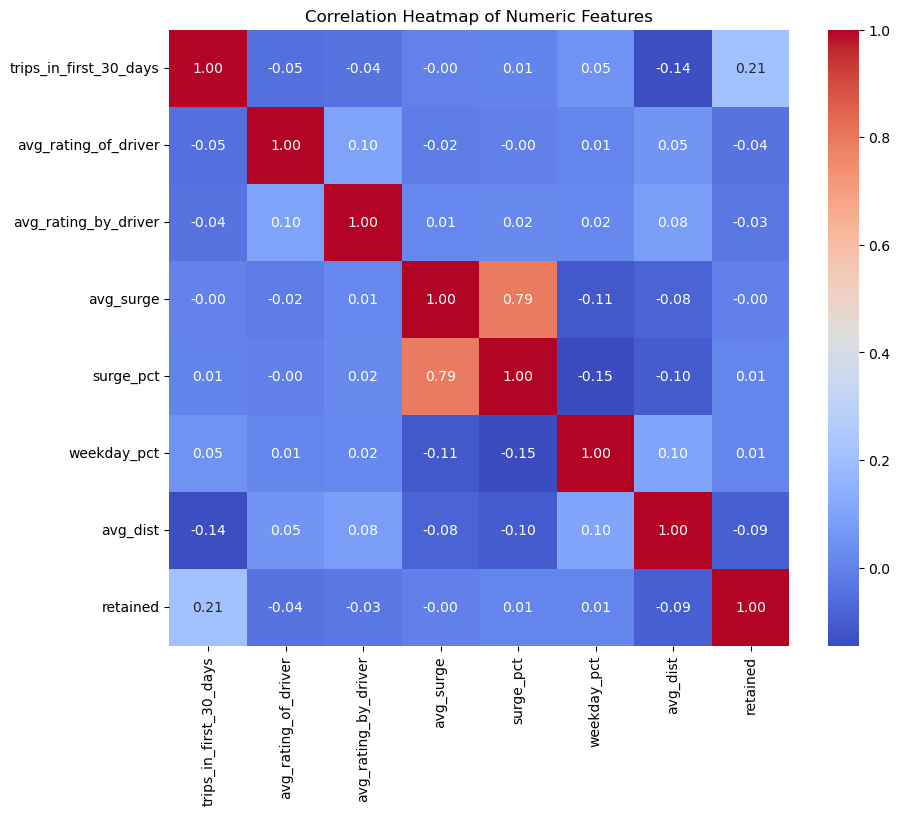

In [12]:
# Numerical valued columns
num_cols = [
    'trips_in_first_30_days',
    'avg_rating_of_driver',
    'avg_rating_by_driver',
    'avg_surge',
    'surge_pct',
    'weekday_pct',
    'avg_dist',
    'retained'
]

# Correlation matrix
corr_matrix = df[num_cols].corr()

# Plotting correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

- About **37.6%** of users were retained.
- Highest retention rate were for users in **King's Landing**, used an **iPhone**, and used the **Ultimate Black** service.
- **trips_in_first_30_days** had the highest positive correlation with retention rate at a moderate 0.21.

## Preprocessing data and training the predictive model

### Data Preprocessing

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# One-hot encode categorical features
encoded_df = pd.get_dummies(df, columns=['city', 'phone', 'ultimate_black_user'], drop_first=True)

# Define features (X) and target (y)
feature_cols = [col for col in encoded_df.columns if col not in ['signup_date', 'last_trip_date', 'retained']]
X = encoded_df[feature_cols]
y = encoded_df['retained']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reassigning X_train and X_test for simplicity of training the model
X_train = X_train_scaled
X_test = X_test_scaled

### Modeling

We are trying to solve a binary classification problem of whether a user will be retained in a given time (6 months in this case).

Since this is a company that is likely still growing, prioritizing retention is crucial. **False negatives** (users who are predicted to churn, but stay) is more costly, therefore our metric to maximize for our model will be **recall**, but with **precision** and **ROC-AUC** as other metrics to keep an eye on.

We will choose between a **Logistic Regression**, **Random Forest**, and **XGBoost** model.

**Logistic Regression**

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import roc_auc_score, make_scorer, precision_score, recall_score

# Initialize the model
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# StratifiedKFold for balanced class distribution across the folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate with recall scores
log_recall_scores = cross_val_score(log_reg, X_train, y_train, cv=cv, scoring='recall')

# Fitting the model
log_reg.fit(X_train, y_train)

# Training predictor variables
y_train_pred_log = log_reg.predict(X_train)
y_train_proba_log = log_reg.predict_proba(X_train)[:,1]

# Training predictor variables
y_test_pred_log = log_reg.predict(X_test)
y_test_proba_log = log_reg.predict_proba(X_test)[:,1]

In [17]:
# Logistic model metrics

# Recall
train_recall_log = recall_score(y_train, y_train_pred_log)
test_recall_log = recall_score(y_test, y_test_pred_log)

# Precision
train_precision_log = precision_score(y_train, y_train_pred_log)
test_precision_log = precision_score(y_test, y_test_pred_log)

# AUC ROC
train_auc_log = roc_auc_score(y_train, y_train_pred_log)
test_auc_log = roc_auc_score(y_test, y_test_pred_log)

log_metrics = {
    "Logistic Regression Cross-Validated Recall (Mean)": log_recall_scores.mean(),
    "Train Recall": train_recall_log,
    "Test Recall": test_recall_log,
    "Train Precision": train_precision_log,
    "Test Precision": test_precision_log,
    "Train ROC AUC": train_auc_log,
    "Test ROC AUC": test_auc_log
}

log_metrics

{'Logistic Regression Cross-Validated Recall (Mean)': 0.5009364548494983,
 'Train Recall': 0.5003344481605351,
 'Test Recall': 0.4915345337274926,
 'Train Precision': 0.6704912154894227,
 'Test Precision': 0.6583873290136789,
 'Train ROC AUC': 0.675853554084715,
 'Test ROC AUC': 0.6692350087992301}

- Baseline model is recalling about half of the true retained users
- Decent precision of 65-67%
- Solid ROC AUC

We're going to tune it more to increase the threshold for this model to boost the recall.

In [22]:
from sklearn.metrics import precision_recall_curve

# Computing the precision-recall curve for thes test set
precisions, recalls, thresholds = precision_recall_curve(y_test, y_test_proba_log)

# Thresholds for max recall with at least 0.60 precision
best_threshold = 0
for p,r,t in zip(precisions, recalls, thresholds):
    if p>= 0.60:
        best_threshold = t
        break

# Applying threshold to get new predictions
y_train_custom_pred = (y_train_proba_log >= best_threshold).astype(int)
y_test_custom_pred = (y_test_proba_log >= best_threshold).astype(int)

# Recalculating metrics
custom_train_recall_log = recall_score(y_train, y_train_custom_pred)
custom_test_recall_log = recall_score(y_test, y_test_custom_pred)

custom_train_precision_log = precision_score(y_train, y_train_custom_pred)
custom_test_precision_log = precision_score(y_test, y_test_custom_pred)

tuned_metrics_log = {
    "Chosen Threshold": best_threshold,
    "Custom Train Recall": custom_train_recall_log,
    "Custom Test Recall": custom_test_recall_log,
    "Custom Train Precision": custom_train_precision_log,
    "Custom Test Precision": custom_test_precision_log
}
tuned_metrics_log

{'Chosen Threshold': 0.3969110577788266,
 'Custom Train Recall': 0.6409364548494983,
 'Custom Test Recall': 0.6299381886589627,
 'Custom Train Precision': 0.613091048691535,
 'Custom Test Precision': 0.6001024065540195}

Lowering the classification threshold successfully boosted recall from around 50% to ~65% with only a slight drop in precision seems to be a worthy tradeoff for tuning the model.

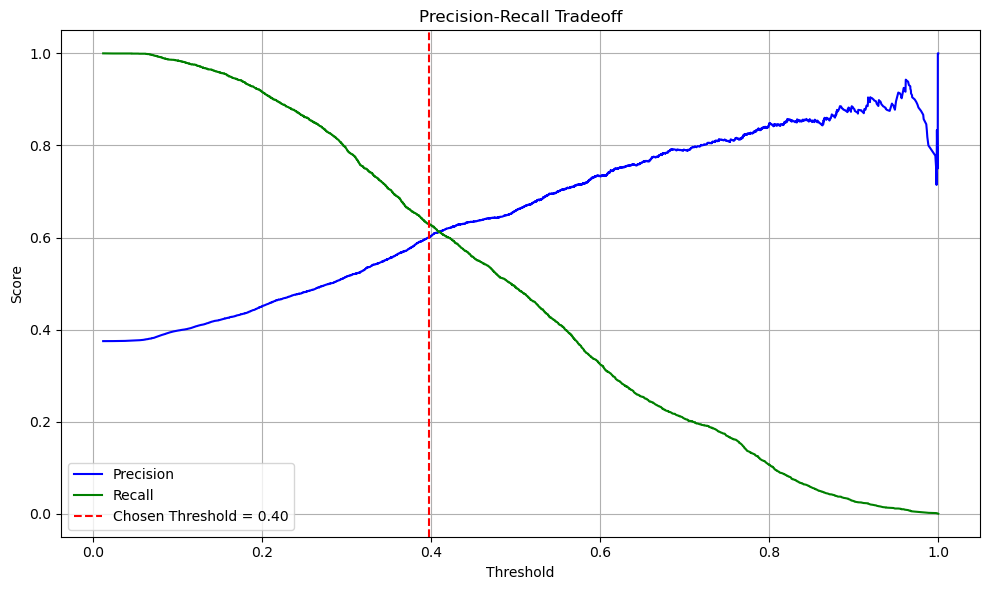

In [21]:
# Plot precision-recall tradeoff
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label="Precision", color="blue")
plt.plot(thresholds, recalls[:-1], label="Recall", color="green")
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f"Chosen Threshold = {best_threshold:.2f}")
plt.title("Precision-Recall Tradeoff")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Random Forest Classification**

In [23]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Predictors for RF training
rf_train_pred = rf_model.predict(X_train)
rf_train_proba = rf_model.predict_proba(X_train)[:, 1]

# Predictors for RF testing
rf_test_pred = rf_model.predict(X_test)
rf_test_proba = rf_model.predict_proba(X_test)[:, 1]


# Evaluate metrics
rf_train_recall = recall_score(y_train, rf_train_pred)
rf_test_recall = recall_score(y_test, rf_test_pred)

rf_train_precision = precision_score(y_train, rf_train_pred)
rf_test_precision = precision_score(y_test, rf_test_pred)

rf_train_auc = roc_auc_score(y_train, rf_train_proba)
rf_test_auc = roc_auc_score(y_test, rf_test_proba)

rf_metrics = {
    "Train Recall": rf_train_recall,
    "Test Recall": rf_test_recall,
    "Train Precision": rf_train_precision,
    "Test Precision": rf_test_precision,
    "Train ROC AUC": rf_train_auc,
    "Test ROC AUC": rf_test_auc
}
rf_metrics

{'Train Recall': 0.9932441471571907,
 'Test Recall': 0.6621875839828003,
 'Train Precision': 0.9981179001142704,
 'Test Precision': 0.6684753119913185,
 'Train ROC AUC': 0.9999412859777203,
 'Test ROC AUC': 0.81811473242538}

While the metrics (specifically ROC AUC and Precision) outperform the Logistic Regression model, the training metrics suggest there is overfitting. We will need to tune this one too.

In [27]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
rf_param_grid = {
    'max_depth': [5, 10],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2']
}

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the model to the training data
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Predict with best model
best_rf_train_proba = best_rf.predict_proba(X_train)[:, 1]
best_rf_test_proba = best_rf.predict_proba(X_test)[:, 1]
best_rf_train_pred = best_rf.predict(X_train)
best_rf_test_pred = best_rf.predict(X_test)

# Evaluate
best_rf_results = {
    "Best Params": grid_search.best_params_,
    "Train Recall": recall_score(y_train, best_rf_train_pred),
    "Test Recall": recall_score(y_test, best_rf_test_pred),
    "Train Precision": precision_score(y_train, best_rf_train_pred),
    "Test Precision": precision_score(y_test, best_rf_test_pred),
    "Train ROC AUC": roc_auc_score(y_train, best_rf_train_proba),
    "Test ROC AUC": roc_auc_score(y_test, best_rf_test_proba)
}

best_rf_results

Fitting 5 folds for each of 36 candidates, totalling 180 fits


{'Best Params': {'max_depth': 10,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 10},
 'Train Recall': 0.6862207357859532,
 'Test Recall': 0.6546627250739049,
 'Train Precision': 0.7799741503839428,
 'Test Precision': 0.7386294724075197,
 'Train ROC AUC': 0.8819691401154295,
 'Test ROC AUC': 0.8488361826078664}

- **Recall** is still strong as before for the test sset, but the precision has improved and there is better generalization.
- **ROC AUC** improved from both the logistic and original RF models (0.85).
- Model is well-balanced and cathes a good proportion of retained users while minimizing false positives.

**XGBoost**

In [28]:
from xgboost import XGBClassifier

# Initialize and fit XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
xgb_train_pred = xgb_model.predict(X_train)
xgb_test_pred = xgb_model.predict(X_test)
xgb_train_proba = xgb_model.predict_proba(X_train)[:, 1]
xgb_test_proba = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate
xgb_results = {
    "Train Recall": recall_score(y_train, xgb_train_pred),
    "Test Recall": recall_score(y_test, xgb_test_pred),
    "Train Precision": precision_score(y_train, xgb_train_pred),
    "Test Precision": precision_score(y_test, xgb_test_pred),
    "Train ROC AUC": roc_auc_score(y_train, xgb_train_proba),
    "Test ROC AUC": roc_auc_score(y_test, xgb_test_proba)
}

xgb_results

{'Train Recall': 0.7351839464882943,
 'Test Recall': 0.6761623219564633,
 'Train Precision': 0.8177218956922848,
 'Test Precision': 0.7354574685764397,
 'Train ROC AUC': 0.9107620098369651,
 'Test ROC AUC': 0.8532819177987186}

Pretty good improvements of the metrics compared to the previous models.

Still, we will tune it to boost performance and try to increase the **recall**.

In [29]:
# XGBoost param grid
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200],
    'min_child_weight': [1, 5],
    'subsample': [0.8, 1.0]
}

# Grid search setup
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=xgb_param_grid,
    scoring='recall',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid_search_xgb.fit(X_train, y_train)

# Evaluate the best model
best_xgb = grid_search_xgb.best_estimator_
xgb_best_train_pred = best_xgb.predict(X_train)
xgb_best_test_pred = best_xgb.predict(X_test)
xgb_best_train_proba = best_xgb.predict_proba(X_train)[:, 1]
xgb_best_test_proba = best_xgb.predict_proba(X_test)[:, 1]

xgb_best_results = {
    "Best Params": grid_search_xgb.best_params_,
    "Train Recall": recall_score(y_train, xgb_best_train_pred),
    "Test Recall": recall_score(y_test, xgb_best_test_pred),
    "Train Precision": precision_score(y_train, xgb_best_train_pred),
    "Test Precision": precision_score(y_test, xgb_best_test_pred),
    "Train ROC AUC": roc_auc_score(y_train, xgb_best_train_proba),
    "Test ROC AUC": roc_auc_score(y_test, xgb_best_test_proba)
}

xgb_best_results

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'Best Params': {'learning_rate': 0.1,
  'max_depth': 5,
  'min_child_weight': 1,
  'n_estimators': 200,
  'subsample': 0.8},
 'Train Recall': 0.7020066889632107,
 'Test Recall': 0.6783122816447191,
 'Train Precision': 0.7817504655493482,
 'Test Precision': 0.7430085369443626,
 'Train ROC AUC': 0.8866747038978295,
 'Test ROC AUC': 0.8571658243101491}

- **Recall** went up by 1.7%
- **Precision** and **AUC** improved slightly
- Generalizes well and doesn't overfit too much.

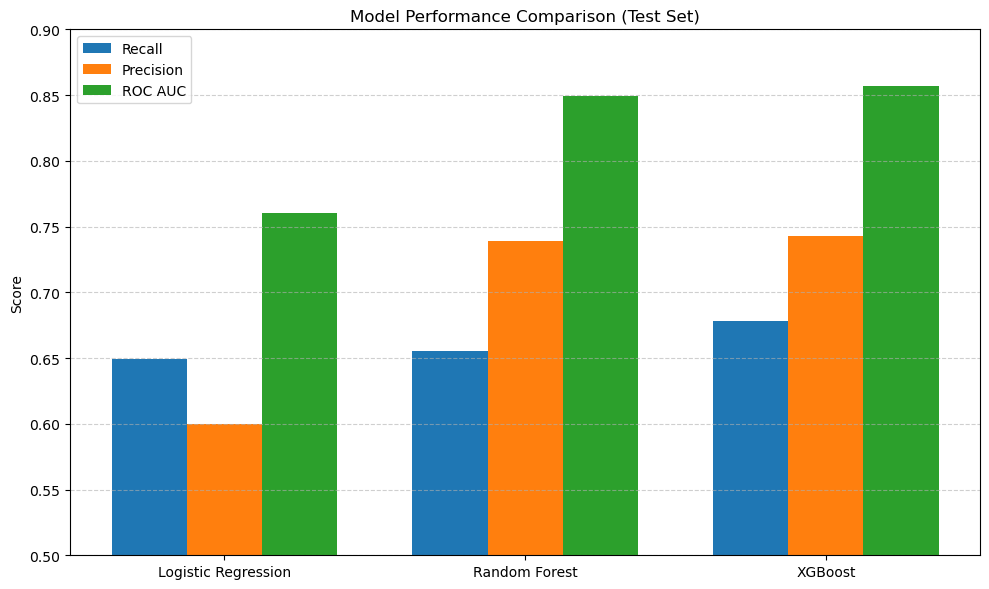

In [30]:
# Plot visualizing the metrics of the models

# Define model performance metrics
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost']
recall_scores = [0.649, 0.655, 0.678]
precision_scores = [0.600, 0.739, 0.743]
auc_scores = [0.760, 0.849, 0.857]

x = np.arange(len(model_names))
width = 0.25

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, recall_scores, width, label='Recall')
ax.bar(x, precision_scores, width, label='Precision')
ax.bar(x + width, auc_scores, width, label='ROC AUC')

# Labeling
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison (Test Set)')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.set_ylim(0.5, 0.9)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

The tuned **XGBoost** will be our model of choice.

- The model's **ROC AUC** and **precision** just edge out the Random Forest model while it's more distinct that it's recall is better than RF's.

I chose a calssification modeling approach using **XGBoost** to predict user retention in their 6th month based on early behavioral and enagement data.

It was compared against a **Logistic Regression** and **Random Forest** classification model, but XGBoost had the best balance of a **recall** score of **67.8%**, **precision** (**74.3%**) and **ROC AUC** (**0.857**). It generalizes well on the test set and avoids overfitting.

A concern is assuming that current user behavior will remain predictive over time, which could shift as the platform evolves. 

The model can be utilized by Ultimate to identify new users at high risk of churning ealry on. This could prompt targeting the users with personalized retention strategires such as onboarding support incentives.

Ultimate could look at insights such as importance of weekday usage and guide product and marketing teams to promote features linked to higher retention. This could enable interventions drive by data to increase long-term engagement and lifetime value.